#### [ ML - 생선 분류 모델 만들기 5 ]
- 주제 : 2개 종류 생선 분류 모델 만들기
- 학습종류 : 지도학습 -> 분류
- 학습방법 : 다양한 분류 알고리즘들 => KNN 최근접이웃알고리즘

- 데이터셋
    * 학습용 데이터셋
        - 모델 학습에 즉, 데이터의 규칙과 패턴 찾기위해서 사용되는 데이터셋

    * 검증용 데이터셋
        - 모델 학습 중 제대로 규칙과 패턴 찾고 있는지 검사하기 위한 데이터셋
        - scikit-learn은 fit() 메서드로 학습 종료되어서 사용할 수 없음.
        - 교차검증, 일부 학습 알고리즘에서는 사용 가능

    * 테스트용 데이터셋
        - 학습 완료 후 성능검사에 사용되는 데이터셋
        - 추가 학습 진행 여부 결정 기준이 됨!
        - ★ 절대 학습에 사용되면 안됨!! ★

[1] 데이터 확인 : 피쳐와 타겟<hr>

In [72]:
## [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 학습알고리즘 모델
from sklearn.neighbors import KNeighborsClassifier
## 데이터셋 관련 
from sklearn.model_selection import train_test_split

In [73]:
## [1-2] 데이터 로딩 및 빙어와 도미 데이터만 추출
DATA_FILE = '../Data/fish.csv'

## 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE,usecols=[0,1,2])
display(allDF.head(3))

## bream 도미, smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

## 행인덱스 초기화
fishDF.reset_index(inplace = True, drop = True)
display(fishDF.head(3),fishDF.tail(3))

display(fishDF.info())


,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


,Species,Weight,Length
46,Smelt,12.2,13.0
47,Smelt,19.7,14.3
48,Smelt,19.9,15.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     object 
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


None

In [74]:
## [1-3] 무게와 길이 피쳐와 품종 분류 가능 여부
## copy_on_write = True
pd.options.mode.copy_on_write = True


## 품종 카테고리형으로 변환 -- 0 / 1 형식으로 나오도록 범주형으로 변환
speciesSR = fishDF.Species
fishDF.Species=speciesSR.astype('category')

In [75]:
## 전체 데이터 타입 확인
fishDF.info()

## 카테고리 접근자 cat 사용
print(f'{fishDF.Species.cat.categories}')
print(f'{fishDF.Species.cat.codes}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  49 non-null     category
 1   Weight   49 non-null     float64 
 2   Length   49 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 1.1 KB
Index(['Bream', 'Smelt'], dtype='object')
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
dtype: int8


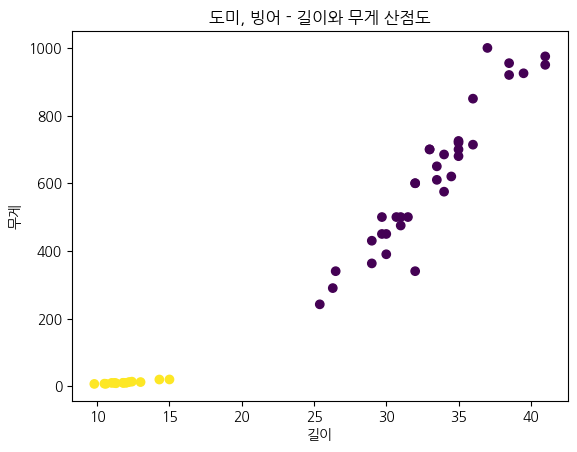

,Weight,Length
Weight,1.000000,0.960347
Length,0.960347,1.000000


In [76]:
## 시각화
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes)
plt.xlabel('길이')
plt.ylabel('무게')
plt.title('도미, 빙어 - 길이와 무게 산점도')
plt.show()


## 상관계수
fishDF.corr(numeric_only=True)

[2] 피쳐 / 데이터와 타겟 / 라벨   분리 <hr>

In [77]:
## 학습용 피쳐/데이터와 타겟/라벨 분리
## -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

## -> 타겟/라벨 : 1D 
targetSR = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.ndim}2D, targetSR : {targetSR.ndim}D')
print(f'featureDF : {featureDF.shape}2D, targetSR : {targetSR.shape}D')

featureDF : 22D, targetSR : 1D
featureDF : (49, 2)2D, targetSR : (49,)D


[3] 학습용, 테스트용 데이터셋 분리 <hr>
- 일반적 => 학습용 : 테스트용 = 8 : 2
- 수집된 데이터에 따라서 학습용 데이터셋 비율 설정
- scikit-learn 기본값 => 7.5 : 2.5

In [78]:
## train_test_split (2차원 피쳐, 1차원 타겟, ... ) => 반환 4개 원소 튜플
## 매개변수
## -> test_size = 0.25 (default)
## -> train_size = 0.75 (default)
## -> random_state = None (default) : 전달한 데이터셋 섞어서 랜덤 추출
## -> stratify = None (default) : 분류 학습 시 꼭 필수 설정, 라벨/타겟 동일 비율 설정

x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)

## 학습용, 테스트용 데이터 개수
print(f'[학습용]   --> {x_train.shape} {x_train.ndim}D,  {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] --> {x_test.shape} {x_test.ndim}D,  {y_test.shape} {y_test.ndim}D')

## 2개 라벨/클래스 Bream, Smelt
## 비율 구하기

targetL = (targetSR.value_counts()/targetSR.shape[0]).to_list()
trainL = (y_train.value_counts()/y_train.shape[0]).to_list()
testL = (y_test.value_counts()/y_test.shape[0]).to_list()


print(f'[Target]  --> Bream : Smelt = {targetL[0]:.3f} : {targetL[1]:.3f}')
print(f'[Train]   --> Bream : Smelt = {trainL[0]:.3f} : {trainL[1]:.3f}')
print(f'[Test]    --> Bream : Smelt = {testL[0]:.3f} : {testL[1]:.3f}')


[학습용]   --> (39, 2) 2D,  (39,) 1D
[테스트용] --> (10, 2) 2D,  (10,) 1D
[Target]  --> Bream : Smelt = 0.714 : 0.286
[Train]   --> Bream : Smelt = 0.718 : 0.282
[Test]    --> Bream : Smelt = 0.700 : 0.300


[4] 스케일러 : 수치형 피쳐들의 값의 범위 일치 조정 <hr>
- scikit-learn의 preprocessing 서브모듈에 기능 제공
- 이상치 체크 후 전처리 방법 결정 필요함

In [79]:
from sklearn.preprocessing import StandardScaler
## 평균 0, 편차 1이 되도록 스케일링 진행 : StandardScaler
## ★★★ 학습용 데이터셋으로 스케일러 생성 ==> 왜? 학습용 데이터에서 규칙/패턴 찾기 때문 ★★★
stdScaler = StandardScaler()
scaled_x_train = stdScaler.fit_transform(x_train)

## => 학습용 데이터로 생성된 스케일러로 변환됨
scaled_x_test = stdScaler.transform(x_test)

print(f'scaled_x_train : {type(scaled_x_train)}')
print(f'scaled_x_test : {type(scaled_x_test)}')

scaled_x_train : <class 'numpy.ndarray'>
scaled_x_test : <class 'numpy.ndarray'>


[3] 학습 진행 <hr>
- 학습 알고리즘의 기본 설정값 그대로 학습 진행 => 성능 점수 : 베이스 점수 / 최저 점수 / 기준 점수
- 성능 향상 위한 하이퍼 파라미터 튜닝 진행 => 학습 알고리즘별 하이퍼 파라미터 체크!

In [80]:
## 훈련용/테스트용 성능 저장
scoreDict = {'Train':[], 'Test':[],'sTrain':[], 'sTest':[]}

## 최근접 이웃수 n_neighbors 범위 : 1 ≤ ~ ≤ √
MAX_K = 31

## 최적 성능의 k 즉, n_neighbor 찾기
for k in range(1,MAX_K):
    ## - 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k)
    sModel = KNeighborsClassifier(n_neighbors=k)
    
    ## - 모델 학습 : 학습용 데이터셋
    kModel.fit(x_train, y_train)
    sModel.fit(scaled_x_train, y_train)

    ## - 모델 성능 평가 : 테스트용 데이터셋
    train_score = kModel.score(x_train, y_train)
    test_score = kModel.score(x_test, y_test)
    print(f'[{k}] train_score : {train_score:.6f}, test_score : {test_score:.6f}')
    strain_score = sModel.score(scaled_x_train, y_train)
    stest_score = sModel.score(scaled_x_test, y_test)
    
    
    
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)
        
    scoreDict['sTrain'].append(strain_score)
    scoreDict['sTest'].append(stest_score)


[1] train_score : 1.000000, test_score : 1.000000
[2] train_score : 1.000000, test_score : 1.000000
[3] train_score : 1.000000, test_score : 1.000000
[4] train_score : 1.000000, test_score : 1.000000
[5] train_score : 1.000000, test_score : 1.000000
[6] train_score : 1.000000, test_score : 1.000000
[7] train_score : 1.000000, test_score : 1.000000
[8] train_score : 1.000000, test_score : 1.000000
[9] train_score : 1.000000, test_score : 1.000000
[10] train_score : 1.000000, test_score : 1.000000
[11] train_score : 1.000000, test_score : 1.000000
[12] train_score : 1.000000, test_score : 1.000000
[13] train_score : 1.000000, test_score : 1.000000
[14] train_score : 1.000000, test_score : 1.000000
[15] train_score : 1.000000, test_score : 1.000000
[16] train_score : 1.000000, test_score : 1.000000
[17] train_score : 1.000000, test_score : 1.000000
[18] train_score : 1.000000, test_score : 1.000000
[19] train_score : 0.974359, test_score : 1.000000
[20] train_score : 0.974359, test_score 

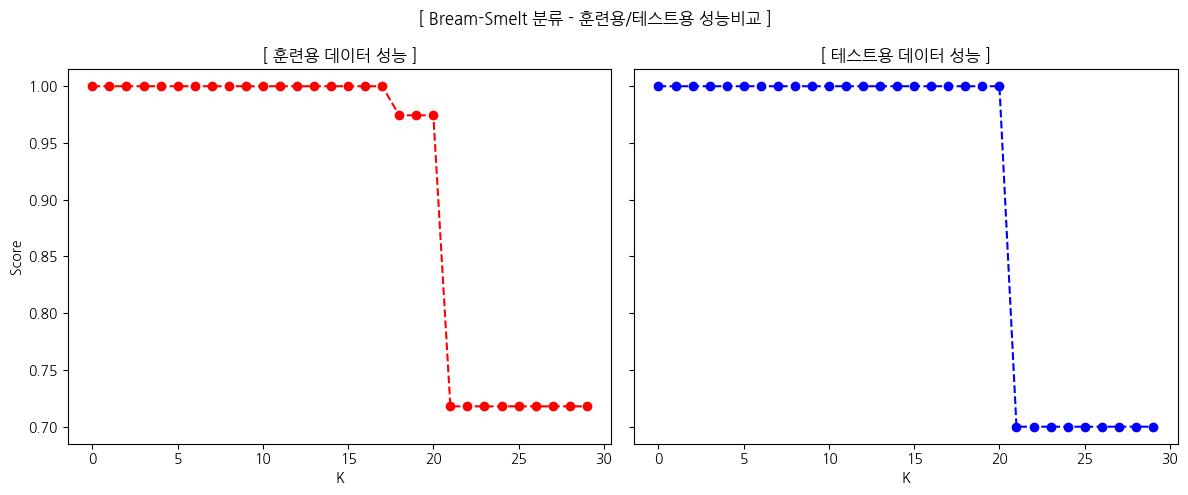

In [81]:
## - K 개수에 따른 점수 시각화
fig, axes = plt.subplots(1,2,sharey = True, figsize=(12,5))

plt.suptitle('[ Bream-Smelt 분류 - 훈련용/테스트용 성능비교 ]')

axes[0].plot(scoreDict['Train'], 'ro--')
axes[0].set_title('[ 훈련용 데이터 성능 ]')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')


axes[1].plot(scoreDict['Test'], 'bo--')
axes[1].set_title('[ 테스트용 데이터 성능 ]')
axes[1].set_xlabel('K')


plt.tight_layout()
plt.show()


In [82]:
## ================================================
## => 최적의 K = 3 : 홀수. 학습한 모델 인스턴스 생성
## ================================================
kModel = KNeighborsClassifier(n_neighbors=3)
kModel.fit(x_train,y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [83]:
sModel = KNeighborsClassifier(n_neighbors=3)
sModel.fit(scaled_x_train,y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가 : 테스트용 데이터셋 <hr>
- 학습이 잘 되었는지 비교 평가
- 학습용 데이터셋 성능과 테스트용 데이터셋 성능 비교
- 평가
    * Good : 학습용 점수와 테스트용 점수 비슷 또는 테스트용 점수가 높음
    * Bad  : 학습용 점수와 테스트용 점수 낮은 경우 / 테스트용 점수만 낮은 경우

In [84]:
## 학습용/테스트용 점수 계산  -->  테스트용이 높게 나와야 좋은 모델
train_score = kModel.score(x_train, y_train)
test_score = kModel.score(x_test, y_test)

strain_score = sModel.score(scaled_x_train, y_train)
stest_score = sModel.score(scaled_x_test, y_test)

print(f'[Train] {train_score}, [Test] {test_score}')
print(f'[sTrain] {strain_score}, [sTest] {stest_score}')

[Train] 1.0, [Test] 1.0
[sTrain] 1.0, [sTest] 1.0


[6] 예측 : 학습용/테스트용 아닌 일반 데이터들<hr>
- 입력 데이터에 대한 예측 결과를 반환 
- 예) 무게, 길이 입력 => bream, smelt 반환

In [85]:
## W, L = 6.7 , 9.8
in_data = [150 ,25]
new_data = pd.DataFrame([in_data], columns=fishDF.columns[1:])
kModel.predict(new_data).item()     ## ndarray에서 원소 1개 있는 경우 item() 원소 추출

'Smelt'

In [86]:
## 학습용 스케일러로 스케일링해서 예측 해야됨
scaled_new_data = stdScaler.transform(new_data)

sModel.predict(scaled_new_data).item()

'Bream'

In [87]:
## 예측 검사 => K개 이웃 데이터 확인
_, indices = kModel.kneighbors(new_data)
_, sindices = sModel.kneighbors(scaled_new_data)

indices[0].tolist()
sindices[0].tolist()

[7, 13, 32]

,Species,Weight,Length
7,Bream,390.0,30.0
4,Bream,430.0,29.0
5,Bream,450.0,29.7


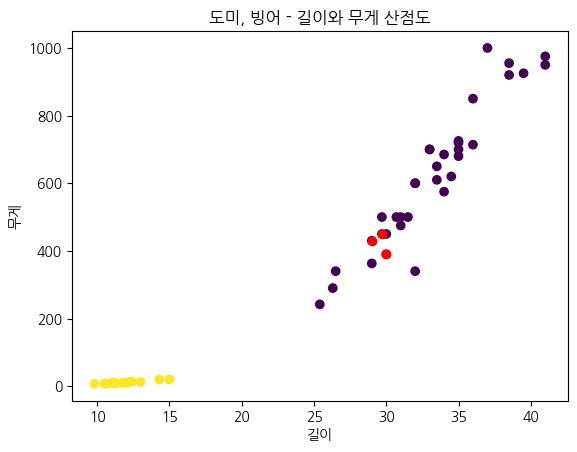

In [88]:
display(fishDF.loc[indices[0].tolist()])

## 시각화
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes)
# plt.plot(new_data, '^r')
## 인접데이터
plt.scatter(fishDF.loc[indices[0].tolist()].Length,fishDF.loc[indices[0].tolist()].Weight,c='red')

plt.xlabel('길이')
plt.ylabel('무게')
plt.title('도미, 빙어 - 길이와 무게 산점도')
plt.show()



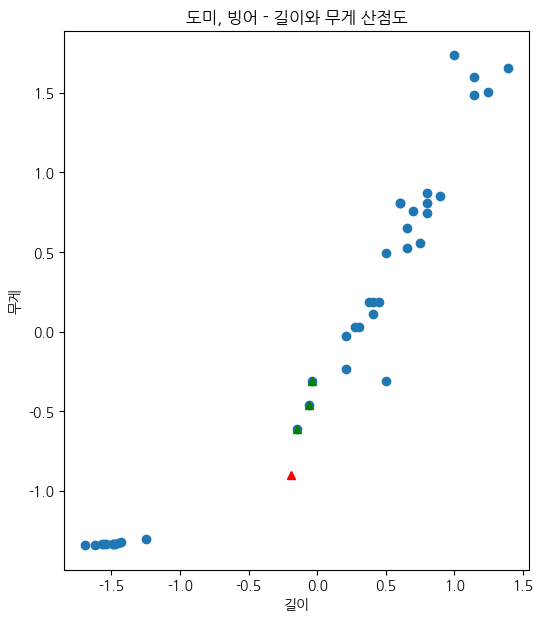

In [93]:
## 시각화
plt.figure(figsize=(6,7))
plt.scatter(scaled_x_train[:,1], scaled_x_train[:, 0])

plt.plot(scaled_new_data[0][1],scaled_new_data[0][0], '^r')

sind = sindices[0].tolist()

## 이웃 인덱스
for x in sind :
    plt.plot(scaled_x_train[x][1], scaled_x_train[x][0], '^g')

plt.xlabel('길이')
plt.ylabel('무게')
plt.title('도미, 빙어 - 길이와 무게 산점도')
plt.show()



In [ ]:
## length, weight 값의 범위
x_train.describe().loc[['min', 'max']]

,Weight,Length
min,6.7,9.8
max,1000.0,41.0
